Machine Learning with Probabilistic Programming 2020

In [92]:
import DTSBN
import read_data
import test_pred
import torch 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to
import pyro.contrib.gp as gp
import math
import numpy as np


In [78]:
#Load the data
data = torch.load('data.pt')

train_data = data[:, :int(data.size()[1]/3)*2]
test_data = data[:, int(data.size()[1]/3)*2:]

In [45]:
#Define the base model
data_size = 1404
hidden_size = 1404
dims = [hidden_size, data_size]
DTSBN_base = DTSBN.DTSBN(dims, 1, 1)

#Define the Data Dependent Baseline
dims.reverse()
DDBL_base = DTSBN.DDBL(dims)

In [46]:
#Show trainning of model
DTSBN.Adam(DTSBN_base, DDBL_base, train_data, torch.nn.MSELoss(), epochs=15, Noisy=False)

epoch 1 average loss: -1054.8012390865063
epoch 2 average loss: -534.02863306305
epoch 3 average loss: -464.90337908979245
epoch 4 average loss: -421.9748430274836
epoch 5 average loss: -386.1439402723654
epoch 6 average loss: -353.1906691667288
epoch 7 average loss: -317.2585984550968
epoch 8 average loss: -284.3782674930545
epoch 9 average loss: -248.98103383503553
epoch 10 average loss: -217.01967619028753
epoch 11 average loss: -184.16354818048228
epoch 12 average loss: -148.72810813521428
epoch 13 average loss: -112.61006083522605
epoch 14 average loss: -78.21529338924938
epoch 15 average loss: -43.55181816483454


[-1054.8012390865063,
 -534.02863306305,
 -464.90337908979245,
 -421.9748430274836,
 -386.1439402723654,
 -353.1906691667288,
 -317.2585984550968,
 -284.3782674930545,
 -248.98103383503553,
 -217.01967619028753,
 -184.16354818048228,
 -148.72810813521428,
 -112.61006083522605,
 -78.21529338924938,
 -43.55181816483454]

In [28]:
#Load the fully trained model


In [73]:
#Define the posterior predictive checks

#Check the n_forward day returns in the generated data against real data
def graph_rets(actual_d, data_recovery_path, DTSBN_net, n_preds, n_forward):
    
    actual = actual_d.clone()
    with open(data_recovery_path, 'rb') as f:
        data_recov = pickle.load(f)

    states = []
    for st in range(0, len(dims)):
        states.append(torch.zeros((dims[st], DTSBN_net.nt)))

    preds = test_pred.predict_n_forward(DTSBN_net, states, n_preds)
    preds = preds[:, 100:]

    for comp in range(0, len(data_recov)):

        actual[comp] = torch.add(torch.mul(actual[comp],
                                               data_recov[comp][1]),
                                     data_recov[comp][0])
        
        preds[comp] = torch.add(torch.mul(preds[comp], data_recov[comp][1]),
                                data_recov[comp][0])

    real_rets = []
    gen_rets = []

    for comp in range(0, len(data_recov)):
        if comp % 3 == 0:

            for start in range(0, actual.size()[1]+1-n_forward):
                r = 1
                for day in range(0, n_forward):
                    r = r*(actual[comp][start+day].item() + 1)
                real_rets.append(r-1)

            for start in range(0, preds.size()[1]+1-n_forward):
                g = 1
                for day in range(0, n_forward):
                    g = g*(preds[comp][start+day].item() + 1)
                gen_rets.append(g-1)

    f1 = sns.distplot(real_rets, hist=False, kde=True,
                      norm_hist=True, label='Actual')
    f1.set_title('{} day returns '.format(n_forward))
    f1.set(xlabel='Return', ylabel='PDF')
    sns.distplot(gen_rets, hist=False, kde=True,
                 norm_hist=True, label='Generated')

    plt.show()

#Check the variance of n_forward day returns in the generated data against real data
def graph_vars(actual_d, data_recovery_path, DTSBN_net, n_preds, n_forward):

    actual = actual_d.clone()
    with open(data_recovery_path, 'rb') as f:
        data_recov = pickle.load(f)

    states = []
    for st in range(0, len(dims)):
        states.append(torch.zeros((dims[st], DTSBN_net.nt)))

    preds = test_pred.predict_n_forward(DTSBN_net, states, n_preds)
    preds = preds[:, 100:]

    for comp in range(0, len(data_recov)):

        actual[comp] = torch.add(torch.mul(actual[comp],
                                               data_recov[comp][1]),
                                     data_recov[comp][0])
        preds[comp] = torch.add(torch.mul(preds[comp], data_recov[comp][1]),
                                data_recov[comp][0])

    real_vars = []
    gen_vars = []

    for comp in range(0, len(data_recov)):
        if comp % 3 == 0:
            r_l = []
            g_l = []
            for start in range(0, actual.size()[1]+1-n_forward):
                r = 1
                for day in range(0, n_forward):
                    r = r*(actual[comp][start+day].item() + 1)
                r_l.append(r-1)
            real_vars.append(torch.var(torch.tensor(r_l)).item())
            for start in range(0, preds.size()[1]+1-n_forward):
                g = 1
                for day in range(0, n_forward):
                    g = g*(preds[comp][start+day].item() + 1)
                g_l.append(g-1)
            gen_vars.append(torch.var(torch.tensor(g_l)).item())

    f1 = sns.distplot(real_vars, hist=False, kde=True,
                      norm_hist=True, label='Actual')
    f1.set_title('{} day returns standard deviation'.format(n_forward))
    f1.set(xlabel='Standard Deviation', ylabel='PDF')
    sns.distplot(gen_vars, hist=False, kde=True,
                 norm_hist=True, label='Generated')

    plt.show()

/Users/jonahdeykin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


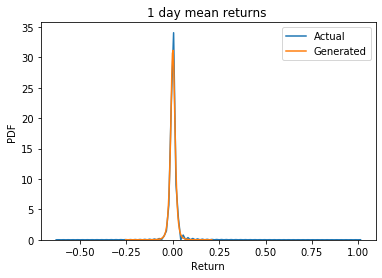

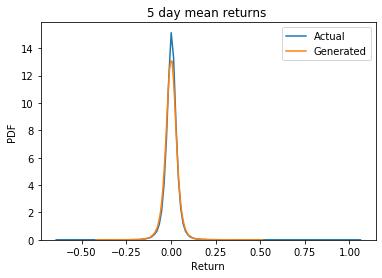

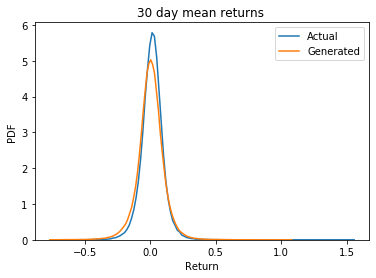

In [75]:
graph_rets(train_data, 'data_recovery.txt', DTSBN_base, 1100, 1)
graph_rets(train_data, 'data_recovery.txt', DTSBN_base, 1100, 5)
graph_rets(train_data, 'data_recovery.txt', DTSBN_base, 1100, 30)


/Users/jonahdeykin/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


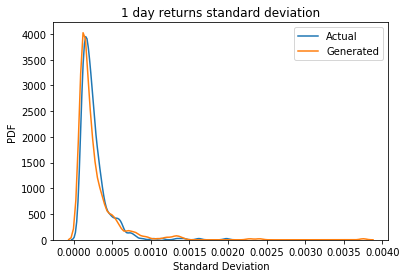

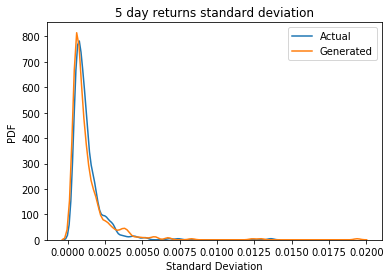

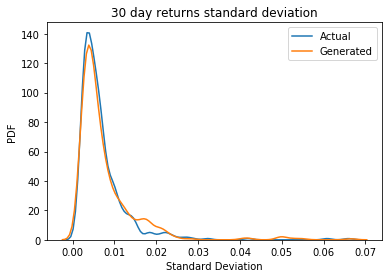

In [76]:
graph_vars(train_data, 'data_recovery.txt', DTSBN_base, 1100, 1)
graph_vars(train_data, 'data_recovery.txt', DTSBN_base, 1100, 5)
graph_vars(train_data, 'data_recovery.txt', DTSBN_base, 1100, 30)


In [ ]:
#Load Grid Search Optimized Model
DTSBN_grid = 'filler'


In [ ]:
graph_rets(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 1)
graph_rets(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 5)
graph_rets(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 30)

In [ ]:
graph_vars(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 1)
graph_vars(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 5)
graph_vars(train_data, 'data_recovery.txt', DTSBN_grid, 1100, 30)

In [85]:
class bayesian_op():
    def __init__(self):
        self.ranges = None
        self.data = None
        self.gpmodel = None
        self.time_limit = None

    def run(self, ranges, data, warmup, bayesian, time_limit):

        self.ranges = ranges
        self.data = data
        self.time_limit = time_limit

        X = torch.rand((warmup, 3))
        y = torch.zeros((warmup,))

        for j in range(0, warmup):
            configs = [((self.ranges[i][1]-self.ranges[i][0]) *
                        X[j][i].item())
                       + self.ranges[i][0] for i in range(0, 3)]
            dims = [self.data.size()[0]]

            for _ in range(0, int(configs[1])):
                dims.append(max(1, int(dims[-1] / configs[0])))

            DDBL_net = DTSBN.DDBL(dims)
            dims.reverse()
            DTSBN_net = DTSBN.DTSBN(dims, int(configs[1]), int(configs[2]))

            y[j] = DTSBN.Adam(DTSBN_net, DDBL_net, self.data, torch.nn.MSELoss(),
                        t_max=self.time_limit, Noisy=False)
            print('warmup step {}/{}'.format(j+1, warmup))
        self.gpmodel = gp.models.GPRegression(X, y,
                                              gp.kernels.Matern52(
                                                                  input_dim=3
                                                                  ),
                                              noise=torch.tensor(0.1),
                                              jitter=1.0e-4)

        for j in range(0, bayesian):
            x_min = self.next_x()
            self.update_posterior(x_min)
            print('bayesian step {}/{}'.format(j+1, bayesian))

        return (self.gpmodel.X, self.gpmodel.y)

    def update_posterior(self, x_new):

        configs = [((self.ranges[i][1]-self.ranges[i][0]) * x_new[i].item()) +
                   self.ranges[i][0] for i in range(0, 3)]
        dims = [self.data.size()[0]]

        for _ in range(0, int(configs[1])):
            dims.append(max(1, int(dims[-1] / configs[0])))

        DDBL_net = DTSBN.DDBL(dims)
        dims.reverse()
        DTSBN_net = DTSBN.DTSBN(dims, int(configs[1]), int(configs[2]))

        y = torch.tensor(DTSBN.Adam(DTSBN_net, DDBL_net, self.data, torch.nn.MSELoss(),
                              t_max=self.time_limit, Noisy=False))
        x_fix = torch.zeros((1, 3))
        x_fix[0] = x_new
        X = torch.cat([self.gpmodel.X, x_fix])
        y_fix = torch.zeros((1,))
        y_fix[0] = y
        y = torch.cat([self.gpmodel.y, y_fix])

        self.gpmodel.set_data(X, y)

        # optimize the GP hyperparameters using Adam with lr=0.001
        optimizer = torch.optim.Adam(self.gpmodel.parameters(), lr=0.001)
        gp.util.train(self.gpmodel, optimizer)

    def lower_confidence_bound(self, x, kappa=2):

        x_fix = torch.zeros((1, x.size()[0]))
        x_fix[0] = x
        mu, variance = self.gpmodel(x_fix, full_cov=False, noiseless=False)
        sigma = variance.sqrt()
        return -mu - kappa * sigma

    def find_a_candidate(self, x_init, lower_bound=0, upper_bound=1):
        # transform x to an unconstrained domain
        constraint = constraints.interval(lower_bound, upper_bound)
        unconstrained_x_init = transform_to(constraint).inv(x_init)
        unconstrained_x = (unconstrained_x_init.clone().detach()
                           .requires_grad_(True))
        minimizer = optim.LBFGS([unconstrained_x],
                                line_search_fn='strong_wolfe')

        def closure():
            minimizer.zero_grad()
            x = transform_to(constraint)(unconstrained_x)
            y = self.lower_confidence_bound(x)
            autograd.backward(unconstrained_x, autograd.grad(y,
                                                             unconstrained_x))
            return y

        minimizer.step(closure)
        # after finding a candidate in the unconstrained domain,
        # convert it back to original domain.
        x = transform_to(constraint)(unconstrained_x)
        return x.detach()

    def next_x(self, lower_bound=0, upper_bound=1, num_candidates=5):
        candidates = []
        values = []

        x_init = self.gpmodel.X[-1]
        for i in range(num_candidates):
            x = self.find_a_candidate(x_init, lower_bound, upper_bound)
            y = self.lower_confidence_bound(x)
            candidates.append(x)
            values.append(y)
            x_init = x.new_empty(3).uniform_(lower_bound, upper_bound)

        argmin = torch.min(torch.cat(values), dim=0)[1].item()
        return candidates[argmin]


In [86]:
bayesian = bayesian_op()
candidates = bayesian.run( ((1, 10), (1, 6), (1, 6)), data, 7, 13, 15)

epoch 1 average loss: -1523.60796875
warmup step 1/7
epoch 1 average loss: -1359.5342307692308
warmup step 2/7
epoch 1 average loss: -1362.14453125
warmup step 3/7
epoch 1 average loss: -1518.709125
warmup step 4/7
epoch 1 average loss: -1472.9691666666668
warmup step 5/7
epoch 1 average loss: -1378.7551785714286
warmup step 6/7
epoch 1 average loss: -1363.58515625
warmup step 7/7
epoch 1 average loss: -1586.066125
bayesian step 1/13
epoch 1 average loss: -1344.6537162162163
epoch 2 average loss: -1143.0882352941176
epoch 3 average loss: -956.2538751987281
epoch 4 average loss: -881.6864069952305
bayesian step 2/13
epoch 1 average loss: -1344.3659578696343
epoch 2 average loss: -1144.3822535771064
epoch 3 average loss: -955.6607710651829
epoch 4 average loss: -866.6192368839428
bayesian step 3/13
epoch 1 average loss: -1347.2973966613672
epoch 2 average loss: -1145.956081081081
epoch 3 average loss: -956.8043521462639
epoch 4 average loss: -927.9289546899842
bayesian step 4/13
epoch 1 

In [93]:
def hyperband(budget, ranges, eta, data):

    s_max = math.floor(math.log(budget))
    b = (s_max+1)*budget

    s_list = [i for i in range(0, s_max + 1)]
    s_list.reverse()
    best_configs = torch.zeros((s_max+1, 5))

    tot = 0
    for s in s_list:
        n = math.ceil((b/budget)*(eta**s)/(s+1))
        r = int(budget*eta**-s)
        configs = []
        for _ in range(0, n):
            rands = np.random.uniform(size=(n,))
            config = [((ranges[i][1]-ranges[i][0])*rands[i])+ranges[i][0]
                      for i in range(0, 3)]

            dims = [data.size()[0]]
            for _ in range(0, int(config[1])):
                dims.append(max(int(dims[-1] / config[0]), 1))

            DDBL_net = DTSBN.DDBL(dims)
            dims.reverse()
            DTSBN_net = DTSBN.DTSBN(dims, int(config[1]), int(config[2]))

            configs.append([0, (DTSBN_net, DDBL_net), config])

        for i in range(0, s+1):
            n_i = math.floor(n*eta**-i)
            r_i = r * eta**i
            new_configs = []
            for config in configs:
                tot += r_i

                loss = DTSBN.Adam(config[1][0], config[1][1], data, torch.nn.MSELoss(),
                            t_max=r_i, Noisy=False)
                new_configs.append([loss, config[1], config[2]])

            new_configs.sort(key=lambda x: -x[0])

            configs = new_configs[:max(1, math.floor(n_i/eta))]

            print(i, s, s_max)
            if len(configs) == 1:
                break

        best_configs[s_max-s][0] = configs[0][0]
        best_configs[s_max-s][1] = configs[0][2][0]
        best_configs[s_max-s][2] = configs[0][2][1]
        best_configs[s_max-s][3] = configs[0][2][2]

    return(best_configs)

In [94]:
hyperband(15, ((1, 10), (1, 6), (1, 6)), 3, train_data)

epoch 1 average loss: -1470.8428125
epoch 1 average loss: -1523.41390625
epoch 1 average loss: -1513.16171875
epoch 1 average loss: -1472.53765625
epoch 1 average loss: -1515.995
epoch 1 average loss: -1486.0021875
epoch 1 average loss: -1418.9965625
epoch 1 average loss: -1411.28075
epoch 1 average loss: -1512.3175
0 2 2
epoch 1 average loss: -1309.1139166666667
epoch 1 average loss: -1332.7797916666666
epoch 1 average loss: -1420.0121875
1 2 2
epoch 1 average loss: -1439.28825
epoch 1 average loss: -1602.3834375
epoch 1 average loss: -1575.068125
epoch 1 average loss: -1587.03359375
epoch 1 average loss: -1560.9265625
0 1 2
epoch 1 average loss: -1383.662291169451
epoch 2 average loss: -1235.7113663484488
epoch 3 average loss: -1099.1642303102626
epoch 4 average loss: -964.5821897374701
epoch 5 average loss: -948.3697046539379
epoch 1 average loss: -1313.3914081145585
epoch 2 average loss: -993.2963902147972
epoch 3 average loss: -703.4055787589499
epoch 1 average loss: -1353.2555681

tensor([[-1.3091e+03,  7.0095e+00,  2.4313e+00,  1.7532e+00,  0.0000e+00],
        [-1.4393e+03,  9.1994e+00,  4.7818e+00,  2.0120e+00,  0.0000e+00],
        [-7.0341e+02,  3.8544e+00,  4.4879e+00,  1.4199e+00,  0.0000e+00]])

In [ ]:
#Load Trained Models
DTSBN_hyp = 'filler'
DTSBN_bo = 'filler'

In [ ]:
graph_rets(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 1)
graph_rets(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 5)
graph_rets(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 30)

In [ ]:
graph_rets(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 1)
graph_rets(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 5)
graph_rets(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 30)

In [ ]:
graph_vars(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 1)
graph_vars(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 5)
graph_vars(train_data, 'data_recovery.txt', DTSBN_hyp, 1100, 30)

In [ ]:
graph_vars(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 1)
graph_vars(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 5)
graph_vars(train_data, 'data_recovery.txt', DTSBN_bo, 1100, 30)

In [90]:
samples_bo = test_pred.sample_n_forward(DTSBN_bo, 'data.pt', int(data.size()[1]*2/3), 3, 5, steps_back)


NameError: name 'DTSBN_net' is not defined